# Cats and Dogs Classifier

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          23545        654  1.0              
mauryansshivam/netflix-ott-revenue-and-subscribers-csv-file           Netflix OTT Revenue and Subscribers (CSV File)        2KB  2023-05-13 17:40:23           1382         33  1.0              
darshanprabhu09/stock-prices-for                                      Stock prices of Amazon , Microsoft , Google, Apple   85KB  2023-05-16 15:17:16           1257         34  1.0           

In [3]:
! kaggle datasets download -d tongpython/cat-and-dog

 97% 212M/218M [00:02<00:00, 107MB/s]
100% 218M/218M [00:02<00:00, 92.0MB/s]


In [4]:
! unzip -q cat-and-dog.zip -d cats_dogs
! rm cat-and-dog.zip

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [6]:
data_dir = './cats_dogs'

# Transforms for the training data and testing data
# All pre-trained models expect input images normalized in the same way
train_transforms = transforms.Compose([transforms.RandomRotation(30), # Rotate the image by 30 degrees.
                                       transforms.RandomResizedCrop(224), #Crop a random portion of the input and resize it to a given size.
                                       transforms.RandomHorizontalFlip(), #Horizontally flip the given image randomly with a given probability default prob .5
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here
train_data = datasets.ImageFolder(data_dir + '/training_set/training_set/', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test_set/test_set/', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [7]:
data_iter = iter(trainloader)
images, labels =  next(data_iter)
print(labels)

tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])


In [8]:
# model pre-trained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT) #resnet50
# model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 99.2MB/s]


In [9]:
# Use GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Freeze parameters so we don't backprop through them
# we don't train this part of the model because we are only using it as a feature extractor
for param in model.parameters():
    param.requires_grad = False

# add a classifier to the end of the ResNet Pretrained model
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [11]:
model.to(device)
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.518.. Test loss: 0.092.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.197.. Test loss: 0.053.. Test accuracy: 0.984
Epoch 1/1.. Train loss: 0.165.. Test loss: 0.045.. Test accuracy: 0.988
Epoch 1/1.. Train loss: 0.147.. Test loss: 0.043.. Test accuracy: 0.987
Epoch 1/1.. Train loss: 0.165.. Test loss: 0.042.. Test accuracy: 0.988
Epoch 1/1.. Train loss: 0.147.. Test loss: 0.044.. Test accuracy: 0.987
Epoch 1/1.. Train loss: 0.147.. Test loss: 0.044.. Test accuracy: 0.987
Epoch 1/1.. Train loss: 0.170.. Test loss: 0.072.. Test accuracy: 0.974
Epoch 1/1.. Train loss: 0.210.. Test loss: 0.043.. Test accuracy: 0.988
Epoch 1/1.. Train loss: 0.146.. Test loss: 0.057.. Test accuracy: 0.980
Epoch 1/1.. Train loss: 0.158.. Test loss: 0.039.. Test accuracy: 0.988
Epoch 1/1.. Train loss: 0.160.. Test loss: 0.038.. Test accuracy: 0.989


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
filename = "/content/drive/MyDrive/ML_Practice_projects_colab/Pytorch/Save_Models/Model_Parameters_53123.pth"
torch.save(model.state_dict(), filename)

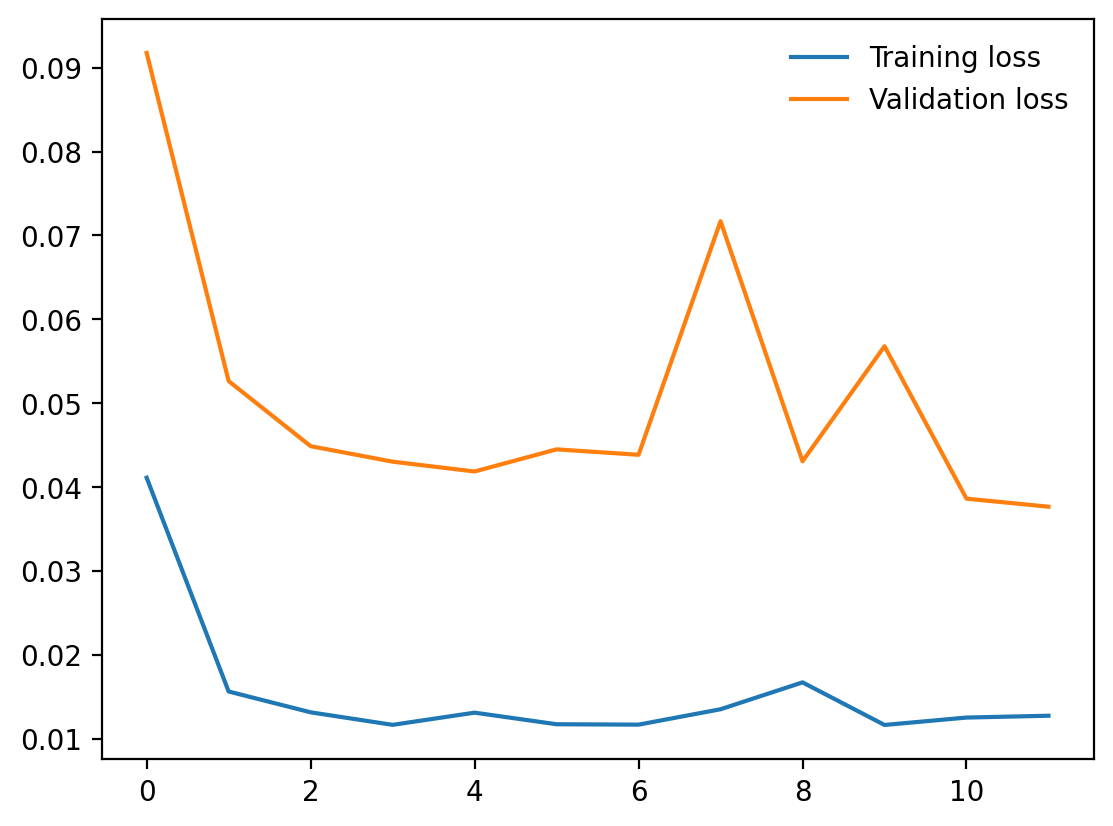

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [24]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    invTrans = transforms.Compose([transforms.Normalize([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]),
                                   transforms.Normalize([-0.485, -0.456, -0.406],[ 1., 1., 1. ])])

    img = invTrans(img)
    # print(img.numpy().shape)
    img = np.einsum('kij->ijk', img.numpy().squeeze())
    # print(img.shape)
    _ , (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    cats_dogs = ['Cat', 'Dog']
    ax2.set_yticklabels(cats_dogs, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout() # Adjust the padding between and around subplots.

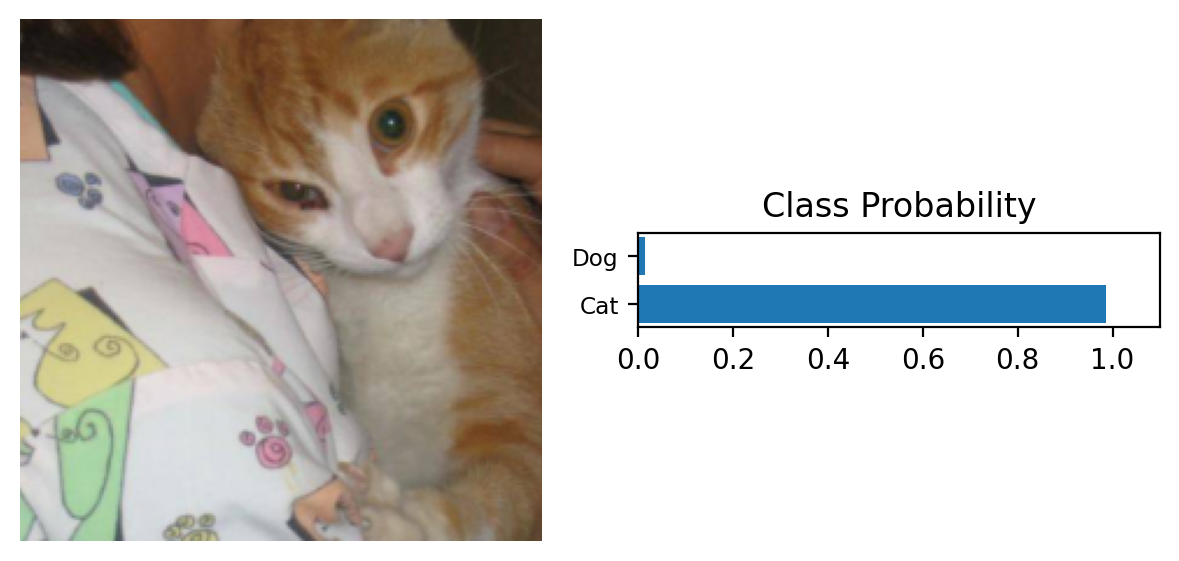

In [25]:
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
idx = np.random.randint(len(images), size=1)
img = images[idx].to(device)
# print(img.shape)
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
img = img.cpu()
view_classify(img, ps.cpu())